In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from nltk.tokenize.toktok import ToktokTokenizer
import nltk.data
from progressbar import ProgressBar
import random
import os

In [52]:
#Get vocabulary of size N from OPUS 50k frequency list

def limit_opus_vocabulary(word_freq_file, size):
    with open(word_freq_file, 'r') as f:
        content = f.readlines()
    words = [x.strip().split(' ')[0] for x in content]
    word_freqs = [float(x.strip().split(' ')[1]) for x in content]
    
    vocab = []
    freqs = []
    for w, f in zip(words[0:size], word_freqs[0:size]):
        vocab.append(w)
        freqs.append(f)
        
    #normalize frequencies
    sum_freqs = sum(freqs)
    normalized_freqs = [f/sum_freqs for f in freqs]
    
    return vocab, normalized_freqs

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


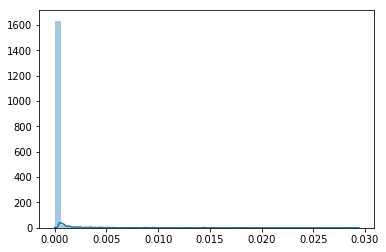

In [53]:
#Create vocabulary of top N frequent words
REFERENCE_VOCAB_SIZE = 5000
opus_reduced_vocab, opus_reduced_freqs = limit_opus_vocabulary('src/opus_fr_50k.txt', REFERENCE_VOCAB_SIZE)
opus_reduced_vocab_dict = {w:opus_reduced_freqs[i] for i, w in enumerate(opus_reduced_vocab)}

#frequency plot on the opus vocabulary
ax = sns.distplot(np.asarray(opus_reduced_freqs))

In [54]:
#Tatoeba filtering
with open('etc/boynames_FR.txt', 'r') as f:
    boynames = f.readlines()
    boynames = [name[0:-1] for name in boynames]
with open('etc/girlnames_FR.txt', 'r') as f:
    girlnames = f.readlines()
    girlnames = [name[0:-1] for name in girlnames]
with open('etc/avoidlist_FR.txt', 'r') as f:
    avoidlist = f.readlines()
    avoidlist = [word[0:-1] for word in avoidlist]
    
MAX_COMMAS = 9
MAX_PERIOD = 6
    
def filter_tatoeba(sent_ids, sents, max_tokens, tom_replacement_set, mary_replacement_set, avoid_set = []):
    filtered_ids = []
    filtered_sents = []
    filtered_sent_tokens = []
    
    pbar = ProgressBar()
    for index in pbar(range(len(sent_ids))):
        sent_id = sent_ids[index]
        sent = sents[index]
        sent_tokens = tokenize_en(sent, True, True)
        if len(sent_tokens) <= max_tokens and sent_tokens.count(',') < MAX_COMMAS and sent_tokens.count('.') < MAX_PERIOD and len(intersection(avoidlist,sent_tokens)) == 0:
            clean_sent = sent
            #Name replacement - tatoeba corpus has an intense use of these two names
            if 'tom' in sent_tokens:
                clean_sent = clean_sent.replace('Tom', tom_replacement_set[random.randint(0,len(tom_replacement_set) - 1)])
            if 'mary' in sent_tokens:
                clean_sent = clean_sent.replace('Mary', mary_replacement_set[random.randint(0,len(mary_replacement_set) - 1)])
                
            filtered_sents.append(clean_sent)
            filtered_ids.append(int(sent_id))
            filtered_sent_tokens.append(sent_tokens)
            
    return filtered_sents, filtered_sent_tokens, filtered_ids

def filter_selected_sents(sents, ids, skip_sent_ids):
    filtered_sents = []
    filtered_ids = []
    for i, s in zip(ids, sents):
        if i not in skip_sent_ids:
            filtered_sents.append(clean_sent)
            filtered_ids.append(sent_id)
    return filtered_sents, filtered_ids
    
#Tokenization and vocab building tools
tokenizer_en = nltk.data.load('tokenizers/punkt/english.pickle')
toktok = ToktokTokenizer()

def tokenize_en(string, to_lower = False, clear_nonalpha = False):
    tokens = []
    if to_lower:
        string = string.lower()
    string = string.strip()

    for sent in tokenizer_en.tokenize(string):
        if clear_nonalpha:
            sent_tokens = [tok for tok in toktok.tokenize(sent) if tok.isalpha()]
        else:
            sent_tokens = [tok for tok in toktok.tokenize(sent)]
        
        tokens.extend(sent_tokens)
    return tokens

def get_vocabulary_from_corpus(sentence_tokens):
    vocab_dict = {}
    total_words = 0
    for tokens in sentence_tokens:
        word_tokens = [tok for tok in tokens if tok.isalpha()]
        for word_token in word_tokens:
            if word_token in vocab_dict:
                vocab_dict[word_token] += 1
            else:
                vocab_dict[word_token] = 1
            total_words += 1
                
    sorted_vocab, sorted_freqs = sort_lists_wrt_list(list(vocab_dict.keys()), list(vocab_dict.values()))

    #normalize frequencies 
    #sum_freqs = sum(sorted_freqs)
    normalized_freqs = [float(f)/float(total_words) for f in sorted_freqs]
    
    print("Total #words:", total_words)
    
    return sorted_vocab, normalized_freqs, total_words

def sort_lists_wrt_list(mylist, values, ascending=False):
    mylist_array = np.array(mylist)
    values_array = np.array(values)  
    
    if ascending:
        inds = values_array.argsort()[::]
    else:
        inds = values_array.argsort()[::-1]
    
    mylist_sorted = mylist_array[inds]
    values_sorted = values_array[inds]
    
    return list(mylist_sorted), list(values_sorted)

def sort_multilists_wrt_list(mylists, values, ascending=False):
    mylists_arrays = [np.array(mylist) for mylist in mylists]
    values_array = np.array(values)  
    
    if ascending:
        inds = values_array.argsort()[::]
    else:
        inds = values_array.argsort()[::-1]
    
    mylists_sorted = [mylist_array[inds] for mylist_array in mylists_arrays]
    values_sorted = values_array[inds]
    
    return [list(mylist_sorted) for mylist_sorted in mylists_sorted], list(values_sorted)

def shuffle_parallel_lists(list_of_lists):
    list_of_arrays = [np.array(l) for l in list_of_lists]
    inds = list(range(0, len(list_of_arrays[0])))
    random.shuffle(inds)
    return [list(l[inds]) for l in list_of_arrays]

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return list(set(lst3))

def difference(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2] 
    return list(set(lst3))

In [55]:
#Read source set
tatoeba_corpus_path = "src/tatoeba_sentences_CC_FR.csv"
with open(tatoeba_corpus_path, 'r') as f:
    content = f.readlines()
    
all_tatoeba_sent_info = [[x.strip().split("\t")[0], x.strip().split("\t")[2]] for x in content]
all_tatoeba_sent_ids = [i[0]for i in all_tatoeba_sent_info]
all_tatoeba_sents = [i[1]for i in all_tatoeba_sent_info]
print('all tatoeba', len(all_tatoeba_sents))

all tatoeba 396342


In [56]:
#Clean the source set
MAX_TOKENS = 40
clean_tatoeba_sents, clean_tatoeba_sent_tokens, clean_tatoeba_ids = filter_tatoeba(all_tatoeba_sent_ids, 
                                                                                   all_tatoeba_sents, 
                                                                                   MAX_TOKENS, 
                                                                                   boynames, 
                                                                                   girlnames, 
                                                                                   avoidlist)

print('clean tatoeba', len(clean_tatoeba_sents))

clean tatoeba 385833


In [111]:
#Read exclude sets from file
exclude_set_files = ['gamayun_fr/FR_kit5k_ids.txt', 'gamayun_fr/FR_kit10k_ids.txt', 'gamayun_fr/FR_kit15k_ids.txt']
exclude_set = []
for file in exclude_set_files:
    to_exclude = []
    with open(file, 'r') as f:
        lines = f.readlines()
        to_exclude = [int(idx[0:-1]) for idx in lines]
    exclude_set.extend(to_exclude)

#Sort it
exclude_set, _ = sort_lists_wrt_list(exclude_set, exclude_set, ascending=True)

In [112]:
#Set include set
include_set_ids = ready_fr_id[3]
include_set_sents = ready_fr_sent[3]

In [113]:
#Filter previously stored sentences (exclude_set)
print('all set size', len(clean_tatoeba_ids))
print('exclude set size', len(exclude_set))

filtered_tatoeba_sents = []
filtered_tatoeba_sent_tokens = []
filtered_tatoeba_ids = []

all_pointer = 0
exclude_pointer = 0

while all_pointer < len(clean_tatoeba_ids):
    all_id = clean_tatoeba_ids[all_pointer]
    if exclude_pointer == len(exclude_set): #already at the end of exclude set take the rest from all set
        filtered_tatoeba_sents.append(clean_tatoeba_sents[all_pointer])
        filtered_tatoeba_sent_tokens.append(clean_tatoeba_sent_tokens[all_pointer])
        filtered_tatoeba_ids.append(clean_tatoeba_ids[all_pointer])
        
        all_pointer += 1
    else:
        exclude_id = exclude_set[exclude_pointer]
        while all_id < exclude_id:
            filtered_tatoeba_sents.append(clean_tatoeba_sents[all_pointer])
            filtered_tatoeba_sent_tokens.append(clean_tatoeba_sent_tokens[all_pointer])
            filtered_tatoeba_ids.append(clean_tatoeba_ids[all_pointer])

            all_pointer += 1
            try:
                all_id = clean_tatoeba_ids[all_pointer]
            except:
                break

        all_pointer += 1
        exclude_pointer += 1

print('filtered tatoeba', len(filtered_tatoeba_sents))

all set size 385833
exclude set size 30000
filtered tatoeba 355843


In [114]:
CORPUS_SIZE = 30000

In [115]:
#OPT 1 - Read include set as initial set
naive_corpus_sents_nonfrequent_takenout = include_set_sents
naive_corpus_ids_nonfrequent_takenout = include_set_ids
naive_corpus_senttokens_nonfrequent_takenout = [tokenize_en(sent, True, True) for sent in include_set_sents]

In [ ]:
#OPT 2 - Naive corpus selection: Select C random sentences
shuffled_sents, shuffled_sent_tokens, shuffled_ids = shuffle_parallel_lists([filtered_tatoeba_sents, filtered_tatoeba_sent_tokens, filtered_tatoeba_ids])

naive_corpus_sents = shuffled_sents[0:CORPUS_SIZE]
naive_corpus_sent_tokens = shuffled_sent_tokens[0:CORPUS_SIZE]
naive_corpus_ids = shuffled_ids[0:CORPUS_SIZE]

In [ ]:
#OPT 2 - Build vocabulary on the naive corpus
corpus = naive_corpus_sents
corpus_tokenized = naive_corpus_sent_tokens
reference_vocab = opus_reduced_vocab

corpus_vocab, corpus_freqs, corpus_total_words = get_vocabulary_from_corpus(corpus_tokenized)

intersecting_vocab = intersection(reference_vocab, corpus_vocab)
missing_vocab = difference(reference_vocab, corpus_vocab)
extra_vocab = difference(corpus_vocab, reference_vocab)

print("corpus size", len(corpus))
print("corpus_vocab", len(corpus_vocab))
print("reference vocab", len(reference_vocab))
print("intersecting", len(intersecting_vocab))
print("missing", len(missing_vocab))
print("extra", len(extra_vocab))
print("%.2f%% missing"%(len(missing_vocab)/len(reference_vocab) * 100))

In [ ]:
#OPT 2 - Print out missing words in the order that they appear in opus vocabulary
missing_indexes = [opus_vocab.index(w) for w in still_missing_vocab]
sorted_missing_vocab, sorted_missing_index = sort_lists_wrt_list(missing_vocab, missing_indexes, True)

for w, index in zip(sorted_missing_vocab, sorted_missing_index):
    print("%s - opus ind:%i"%(w, index))

In [ ]:
#OPT 2 - Take out sentences in the corpus: those with non-frequent words and randomly
RANDOM_SENTENCE_TAKEOUT = 5 #size of die to roll, put -1 to skip
count = 0
naive_corpus_sents_nonfrequent_takenout = []
naive_corpus_ids_nonfrequent_takenout = []
naive_corpus_senttokens_nonfrequent_takenout = []
for sent, sent_tokens, sent_id in zip(naive_corpus_sents, naive_corpus_sent_tokens, naive_corpus_ids):
    nonfrequent = False
    for token in sent_tokens:
        if token not in opus_reduced_vocab: #condition for non-frequent = not in opus_reduced_vocab
            nonfrequent = True
            break
            
    #Random sentence extraction
    if not RANDOM_SENTENCE_TAKEOUT == -1:
        dice = random.randint(0,RANDOM_SENTENCE_TAKEOUT)
    else:
        dice = 1

    if not dice == 0:        
        if nonfrequent:
            count += 1
        else:
            naive_corpus_sents_nonfrequent_takenout.append(sent)
            naive_corpus_ids_nonfrequent_takenout.append(sent_id)
            naive_corpus_senttokens_nonfrequent_takenout.append(sent_tokens)

In [116]:
#Build vocabulary on the corpus
corpus = naive_corpus_sents_nonfrequent_takenout
corpus_tokenized = naive_corpus_senttokens_nonfrequent_takenout
reference_vocab = opus_reduced_vocab

reduced_corpus_vocab, reduced_corpus_freqs, reduced_corpus_total_words = get_vocabulary_from_corpus(corpus_tokenized)

intersecting_vocab = intersection(reference_vocab, reduced_corpus_vocab)
missing_vocab = difference(reference_vocab, reduced_corpus_vocab)
extra_vocab = difference(reduced_corpus_vocab, reference_vocab)

print("corpus size", len(corpus))
print("corpus_vocab", len(reduced_corpus_vocab))
print("reference vocab", len(reference_vocab))
print("intersecting", len(intersecting_vocab))
print("missing", len(missing_vocab))
print("extra", len(extra_vocab))
print("%f"%(len(missing_vocab)/len(reference_vocab) * 100))

Total #words: 56386
corpus size 7782
corpus_vocab 6362
reference vocab 5000
intersecting 3392
missing 1608
extra 2970
32.160000


In [117]:
#Search in rest of the sentences in tatoeba which has the missing words
missing_vocab_replacement_coefs = [(REFERENCE_VOCAB_SIZE - opus_reduced_vocab.index(token))/1000 if token in missing_vocab else 0.0 for token in opus_reduced_vocab]
original_missing_vocab_replacement_coefs = missing_vocab_replacement_coefs.copy()

count = 0 
no_missing_in_candidate = []
candidate_replacement_score = []
candidate_sent_index = []
candidate_missing_word_indexes = []
candidate_missing_word_coefs = []
pbar = ProgressBar()
for i in pbar(range(len(filtered_tatoeba_sents))):
    if i < CORPUS_SIZE:
        continue
        
    sent = filtered_tatoeba_sents[i]    
    sent_tokens = filtered_tatoeba_sent_tokens[i]
    missing_in_sent = intersection(sent_tokens, missing_vocab)
    no_missing = len(missing_in_sent)
    extra_in_sent = difference(sent_tokens, opus_reduced_vocab)
    no_extra = len(extra_in_sent)

    
    missing_word_indexes = [opus_reduced_vocab.index(token) for token in missing_in_sent]
    missing_word_replacement_coefs = [missing_vocab_replacement_coefs[token_index] for token_index in missing_word_indexes]    
    replacement_score = sum(missing_word_replacement_coefs)
    
    
    #if no_missing > 0 and no_extra == 0 :
    no_missing_in_candidate.append(no_missing)
    candidate_replacement_score.append(replacement_score)
    candidate_sent_index.append(i)
    candidate_missing_word_indexes.append(missing_word_indexes)
    candidate_missing_word_coefs.append(missing_word_replacement_coefs)
    count += 1
    
[candidate_sent_index_sorted, candidate_missing_word_coefs_sorted, candidate_missing_word_indexes_sorted], candidate_replacement_score_sorted = sort_multilists_wrt_list([candidate_sent_index, candidate_missing_word_coefs, candidate_missing_word_indexes], candidate_replacement_score)    
        
print("no candidate fill-in sents", len(candidate_sent_index_sorted))

100% |########################################################################|


no candidate fill-in sents 325843


In [120]:
#To restore original coefficients before rescoring
missing_vocab_replacement_coefs = original_missing_vocab_replacement_coefs.copy()

In [121]:
#Rescore candidates. Replacement coefficient of a missing word is reduced by once it is seen. 
new_candidate_replacement_score = []
new_candidate_missing_word_coefs = []
for candidate_score, candidate_sent, covered_indexes in zip(candidate_replacement_score_sorted, candidate_sent_index_sorted, candidate_missing_word_indexes_sorted):

    new_missing_word_replacement_coefs = [missing_vocab_replacement_coefs[token_index] for token_index in covered_indexes]
    new_replacement_score = sum(new_missing_word_replacement_coefs)
    new_candidate_missing_word_coefs.append(new_missing_word_replacement_coefs)
    new_candidate_replacement_score.append(new_replacement_score)
    
    #Reduce coef of less frequent words more than frequent words in order to maintain frequency
    for token_index in covered_indexes:
        if token_index < 1000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*60/100
        elif token_index < 2000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*70/100
        elif token_index < 2000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*80/100
        elif token_index < 3000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*90/100
        elif token_index < 4000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*100/100
        elif token_index < 5000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*100/100
        elif token_index < 6000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*100/100
        elif token_index < 7000:
            missing_vocab_replacement_coefs[token_index] -= missing_vocab_replacement_coefs[token_index]*100/100


[new_candidate_sent_index_sorted, new_candidate_missing_word_coefs_sorted, new_candidate_missing_word_indexes_sorted], new_candidate_replacement_score_sorted = sort_multilists_wrt_list([candidate_sent_index_sorted, candidate_missing_word_coefs_sorted, candidate_missing_word_indexes_sorted], new_candidate_replacement_score)    

In [ ]:
#print replacement candidate sentences sorted with their score sum

# sentence_index = candidate_sent_index_sorted
# sentence_coefs = candidate_missing_word_coefs_sorted
# sentence_missing_words = candidate_missing_word_indexes_sorted
# sentence_score = candidate_replacement_score_sorted

sentence_index = new_candidate_sent_index_sorted
sentence_coefs = new_candidate_missing_word_coefs_sorted
sentence_missing_words = new_candidate_missing_word_indexes_sorted
sentence_score = new_candidate_replacement_score_sorted

count = 0
no_fill_in = CORPUS_SIZE - len(naive_corpus_sents_nonfrequent_takenout)
for s_index, s_score, missing_words, coefs in zip(sentence_index, sentence_score, sentence_missing_words, sentence_coefs):
    missing_info=""
    for token_index, coef in zip(missing_words, coefs):
        missing_info += opus_reduced_vocab[token_index]
        missing_info += "("
        missing_info += str(token_index)
        missing_info += "/"
        missing_info += str(coef)
        missing_info += ") "
    
    if no_fill_in - count <= 0:
        print("=========================================================")
    
    print("%s -- %f %s"%(filtered_tatoeba_sents[s_index], s_score, missing_info))
    count += 1

In [ ]:
#Check duplication in fill-in set
fillin_from = new_candidate_sent_index_sorted
fillin_from_tokens = [filtered_tatoeba_sent_tokens[index] for index in new_candidate_sent_index_sorted]

cover_dict = {missing_word:0 for missing_word in missing_vocab}
for sent_tokens in fillin_from_tokens:
    for tok in sent_tokens:
        if tok in cover_dict.keys():
            cover_dict[tok] += 1
            if cover_dict[tok] > 1:
                print("%s is covered %i times"%(tok, cover_dict[tok]))

In [122]:
#Fill in candidate sentences to the reduced corpus

fillin_from = new_candidate_sent_index_sorted
fillin_from_tokens = [filtered_tatoeba_sent_tokens[index] for index in new_candidate_sent_index_sorted]

naive_corpus_sents_frequent_filledin = naive_corpus_sents_nonfrequent_takenout.copy()
naive_corpus_senttokens_frequent_filledin = naive_corpus_senttokens_nonfrequent_takenout.copy()
naive_corpus_ids_frequent_filledin = naive_corpus_ids_nonfrequent_takenout.copy()
print("reduced corpus", len(naive_corpus_sents_nonfrequent_takenout))
for sent_index in new_candidate_sent_index_sorted:
    sent = filtered_tatoeba_sents[sent_index]
    sent_id = filtered_tatoeba_ids[sent_index]
    sent_tokens = filtered_tatoeba_sent_tokens[sent_index]
    naive_corpus_sents_frequent_filledin.append(sent)
    naive_corpus_senttokens_frequent_filledin.append(sent_tokens)
    naive_corpus_ids_frequent_filledin.append(sent_id)
    if len(naive_corpus_sents_frequent_filledin) >= CORPUS_SIZE:
        break
print("filled-in corpus", len(naive_corpus_sents_frequent_filledin))

reduced corpus 7782
filled-in corpus 30000


In [123]:
#Filled-in corpus stats
corpus = naive_corpus_sents_frequent_filledin
corpus_tokens = naive_corpus_senttokens_frequent_filledin
reference_vocab = opus_reduced_vocab

modified_corpus_vocab, modified_corpus_freqs, modified_corpus_total_words = get_vocabulary_from_corpus(corpus_tokens)

intersecting_vocab = intersection(reference_vocab, modified_corpus_vocab)
still_missing_vocab = difference(reference_vocab, modified_corpus_vocab)
still_extra_vocab = difference(modified_corpus_vocab, reference_vocab)

print("corpus size", len(corpus))
print("corpus_vocab", len(modified_corpus_vocab))
print("reference vocab", len(reference_vocab))
print("intersecting", len(intersecting_vocab))
print("still missing", len(still_missing_vocab))
print("still extra", len(still_extra_vocab))
print("%f"%(len(still_missing_vocab)/len(reference_vocab) * 100))

Total #words: 244902
corpus size 30000
corpus_vocab 16086
reference vocab 5000
intersecting 4335
still missing 665
still extra 11751
13.300000


In [124]:
#Write corpus to file (run after doing counts)

CORPUS_DIR = 'gamayun_fr'
CORPUS_ID = 'FR_kit30k'
!mkdir -p $CORPUS_DIR

corpus_path = os.path.join(CORPUS_DIR, CORPUS_ID)
corpus_sents_to_write = naive_corpus_sents_frequent_filledin
corpus_ids_to_write = naive_corpus_ids_frequent_filledin

with open(corpus_path +'_sentences.txt', 'w') as f:
    for s in corpus_sents_to_write:
        f.write(s + "\n")
        
with open(corpus_path +'_ids.txt', 'w') as f:
    for s in corpus_ids_to_write:
        #print(type(s))
        f.write(str(s) + "\n")
    
with open(corpus_path +'_vocab.txt', 'w') as f:
    for s in modified_corpus_vocab:
        f.write(s + "\n")
        
with open(corpus_path +'_missingvocab.txt', 'w') as f:
    for s in still_missing_vocab:
        f.write(s + "\n")
        
with open(corpus_path +'_linkeduntil.txt', 'w') as f:
    f.write(str(len(include_set_ids)) + "\n")        
#-----FIN-----

# Extracting already parallel sents

In [2]:
from urllib.request import urlopen
try: 
    from BeautifulSoup import BeautifulSoup
except ImportError:
    from bs4 import BeautifulSoup

In [42]:
#Get English word ids
sent_id_files = ['/Users/alp/Documents/Corpora/TWB/gamayun-core/core/en/etc/EN_kit5k_ids.txt',
                 '/Users/alp/Documents/Corpora/TWB/gamayun-core/core/en/etc/EN_kit10k_ids.txt',
                 '/Users/alp/Documents/Corpora/TWB/gamayun-core/core/en/etc/EN_kit15k_ids.txt',
                 '/Users/alp/Documents/Corpora/TWB/gamayun-core/core/en/etc/EN_kit30k_ids.txt']

sent_files = ['/Users/alp/Documents/Corpora/TWB/gamayun-core/core/en/kits/EN_kit5k_sentences.txt',
              '/Users/alp/Documents/Corpora/TWB/gamayun-core/core/en/kits/EN_kit10k_sentences.txt',
              '/Users/alp/Documents/Corpora/TWB/gamayun-core/core/en/kits/EN_kit15k_sentences.txt',
              '/Users/alp/Documents/Corpora/TWB/gamayun-core/core/en/kits/EN_kit30k_sentences.txt']

#sent_id_files = ['test_eng_sents.txt']

english_sent_ids = []
english_sent_setid = []
english_dict = {}

for i, (file_id, file_sent) in enumerate(zip(sent_id_files, sent_files)):
    with open(file_id, 'r') as f_id, open(file_sent, 'r') as f_s:
        for line_id, line_sent in zip(f_id, f_s):
            sent_id = line_id.strip()
            sent = line_sent.strip()
            english_sent_ids.append(sent_id)
            english_sent_setid.append(i)
            english_dict[sent_id] = sent

In [45]:
english_dict['5068653']

'Is that your new friend?'

In [21]:
#Determine which ones have french translation

# french_sent_ids = []
# french_sent_texts = []

pbar = ProgressBar()
for en_sent in pbar(english_sent_ids[54528:]):
    try:
        link = "https://tatoeba.org/eng/sentences/show/" + en_sent
        f = urlopen(link)
        myhtml = f.read()

        #default values
        french_sent_text = ""
        french_sent_id = "-1"

        #Parse and find if there is French translation
        parsed_html = BeautifulSoup(myhtml)
        trans_divs = parsed_html.body.find_all('div', attrs={'class':'translation'})
        for trans_div in trans_divs:
            lang_div = trans_div.find('div', attrs={'class':'lang'})
            if lang_div.find('img').attrs['title'] == 'French':
                french_sent_text = trans_div.find('div', attrs={'class':'text'}).text.strip()
                french_sent_id = trans_div.find_all('md-button', attrs={'class': 'md-icon-button'})[-1].attrs['href'].split("/")[-1]
                break

        french_sent_texts.append(french_sent_text)
        french_sent_ids.append(french_sent_id)
    except:
        print("A problem occured. All went well until %i"%len(french_sent_ids))
        break

100% |########################################################################|


##### print(len(english_sent_ids))
print(len(french_sent_ids))

In [29]:
french_sent_ids

['-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '5939177',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '624450',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '1097549',
 '-1',
 '-1',
 '-1',
 '407112',
 '-1',
 '3609653',
 '2415925',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '2292096',
 '-1',
 '-1',
 '-1',
 '-1',
 '3428152',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '4265827',
 '3218207',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '5418970',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '2426067',
 '-1',
 '-1',
 '-1',
 '1593720',
 '-1',
 '-1',
 '1104689',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '6048096',
 '-1',
 '-1',
 '564383',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '-1',
 '4859841',
 '-1',
 '335073',
 '970064',
 '-1',
 '-1',
 '-1',
 '1333995',
 '-1',
 '7839990',
 '5478018',
 '5726883',
 '-1',
 '-1',
 '-1',
 '-1',
 '2926741',
 '-1',
 '-1',
 '-

In [46]:
# with open('french_ids_backup.txt', 'w') as f:
#     for i in french_sent_ids:
#         f.write(i + "\n")
        
with open('french_sents_backup.txt', 'w') as f:
    for i in french_sent_texts:
        f.write(i + "\n")

In [58]:
ready_en_id = {0:[], 1:[], 2:[], 3:[]}
ready_en_sent = {0:[], 1:[], 2:[], 3:[]}
ready_fr_id = {0:[], 1:[], 2:[], 3:[]}
ready_fr_sent = {0:[], 1:[], 2:[], 3:[]}

count = 0
for set_id, en_id, fr_id, fr_sent in zip(english_sent_setid, english_sent_ids, french_sent_ids, french_sent_texts):
    if not fr_id == '-1':
        count += 1
        print("EN: %s (%i), FR: |%s|"%(en_id, set_id, fr_id))
        ready_en_id[set_id].append(en_id)
        ready_en_sent[set_id].append(english_dict[en_id])
        ready_fr_id[set_id].append(fr_id)
        ready_fr_sent[set_id].append(fr_sent)

EN: 3009208 (0), FR: |5939177|
EN: 462498 (0), FR: |624450|
EN: 980726 (0), FR: |1097549|
EN: 303653 (0), FR: |407112|
EN: 2647366 (0), FR: |3609653|
EN: 1755544 (0), FR: |2415925|
EN: 5147588 (0), FR: |2292096|
EN: 2997157 (0), FR: |3428152|
EN: 4265824 (0), FR: |4265827|
EN: 2455514 (0), FR: |3218207|
EN: 1094446 (0), FR: |5418970|
EN: 1488831 (0), FR: |2426067|
EN: 681739 (0), FR: |1593720|
EN: 38349 (0), FR: |1104689|
EN: 6046868 (0), FR: |6048096|
EN: 4664225 (0), FR: |564383|
EN: 2250069 (0), FR: |4859841|
EN: 291869 (0), FR: |335073|
EN: 309705 (0), FR: |970064|
EN: 3771199 (0), FR: |1333995|
EN: 2359666 (0), FR: |7839990|
EN: 5471363 (0), FR: |5478018|
EN: 4496863 (0), FR: |5726883|
EN: 2948913 (0), FR: |2926741|
EN: 6869605 (0), FR: |5382923|
EN: 2185163 (0), FR: |2185821|
EN: 953677 (0), FR: |1565917|
EN: 1908964 (0), FR: |1910398|
EN: 847204 (0), FR: |1035593|
EN: 4826062 (0), FR: |3267|
EN: 3382006 (0), FR: |3249721|
EN: 6815621 (0), FR: |6816109|
EN: 1893596 (0), FR: |4923

EN: 295287 (0), FR: |685712|
EN: 29699 (0), FR: |446519|
EN: 49300 (0), FR: |391389|
EN: 865553 (0), FR: |412001|
EN: 1655788 (0), FR: |1664048|
EN: 3416367 (0), FR: |3381631|
EN: 59674 (0), FR: |1551291|
EN: 569009 (0), FR: |820612|
EN: 969139 (0), FR: |969229|
EN: 45038 (0), FR: |461657|
EN: 37477 (0), FR: |7730410|
EN: 3711935 (0), FR: |4437928|
EN: 1400813 (0), FR: |1697071|
EN: 328053 (0), FR: |892724|
EN: 1019975 (0), FR: |1019991|
EN: 4374659 (0), FR: |4381343|
EN: 2230272 (0), FR: |3474249|
EN: 3381340 (0), FR: |3249786|
EN: 43839 (0), FR: |457962|
EN: 1157847 (0), FR: |1160313|
EN: 272214 (0), FR: |128873|
EN: 4438493 (0), FR: |7561378|
EN: 39574 (0), FR: |12680|
EN: 975244 (0), FR: |975243|
EN: 3024001 (0), FR: |8328983|
EN: 5191388 (0), FR: |8127256|
EN: 73420 (0), FR: |139321|
EN: 1637299 (0), FR: |1637309|
EN: 310802 (0), FR: |430577|
EN: 4587009 (0), FR: |4587166|
EN: 1095256 (0), FR: |1975181|
EN: 23689 (0), FR: |812014|
EN: 280801 (0), FR: |1180326|
EN: 1142294 (0), FR:

EN: 2111917 (1), FR: |6463393|
EN: 2240773 (1), FR: |4805394|
EN: 285986 (1), FR: |1970267|
EN: 284810 (1), FR: |181024|
EN: 46589 (1), FR: |8313991|
EN: 4728692 (1), FR: |4347929|
EN: 2592946 (1), FR: |1128904|
EN: 271809 (1), FR: |458273|
EN: 3045611 (1), FR: |1313981|
EN: 786758 (1), FR: |786761|
EN: 1159914 (1), FR: |132203|
EN: 7517063 (1), FR: |5666506|
EN: 7170831 (1), FR: |4048506|
EN: 2402679 (1), FR: |2371532|
EN: 516747 (1), FR: |545705|
EN: 3598204 (1), FR: |3598466|
EN: 7196595 (1), FR: |5304049|
EN: 2510448 (1), FR: |3625009|
EN: 1268811 (1), FR: |9254|
EN: 7543978 (1), FR: |7547141|
EN: 57202 (1), FR: |1564217|
EN: 1800043 (1), FR: |1816075|
EN: 1789182 (1), FR: |1793268|
EN: 297738 (1), FR: |132272|
EN: 2545391 (1), FR: |6563945|
EN: 2251298 (1), FR: |2354642|
EN: 2716008 (1), FR: |5801890|
EN: 529918 (1), FR: |7929|
EN: 288123 (1), FR: |130533|
EN: 2857154 (1), FR: |4949211|
EN: 59515 (1), FR: |390961|
EN: 3994950 (1), FR: |3994957|
EN: 299897 (1), FR: |1180236|
EN: 18

EN: 41813 (1), FR: |3570806|
EN: 513070 (1), FR: |403910|
EN: 1702279 (1), FR: |1704116|
EN: 325069 (1), FR: |1101490|
EN: 6391351 (1), FR: |6391507|
EN: 6618560 (1), FR: |6618561|
EN: 272734 (1), FR: |2124285|
EN: 244825 (1), FR: |7849252|
EN: 3062005 (1), FR: |5529579|
EN: 322364 (1), FR: |180334|
EN: 1392466 (1), FR: |2023804|
EN: 3731209 (1), FR: |3973921|
EN: 6390165 (1), FR: |6390169|
EN: 3271749 (1), FR: |2878740|
EN: 1028517 (1), FR: |3163038|
EN: 253837 (1), FR: |1075866|
EN: 3730912 (1), FR: |3979819|
EN: 39166 (1), FR: |1168680|
EN: 1092350 (1), FR: |1683156|
EN: 515086 (1), FR: |403910|
EN: 505464 (1), FR: |1804895|
EN: 2223656 (1), FR: |2226593|
EN: 262064 (1), FR: |2010949|
EN: 5927328 (1), FR: |7028891|
EN: 1253327 (1), FR: |1253705|
EN: 582840 (1), FR: |560651|
EN: 73040 (1), FR: |10037|
EN: 567827 (1), FR: |583794|
EN: 5647962 (1), FR: |5648013|
EN: 4013452 (1), FR: |5707272|
EN: 2329584 (1), FR: |5660359|
EN: 37052 (1), FR: |1173431|
EN: 308883 (1), FR: |449984|
EN: 2

EN: 2333018 (2), FR: |1869265|
EN: 3731151 (2), FR: |5494531|
EN: 7521470 (2), FR: |7752044|
EN: 2402255 (2), FR: |2402998|
EN: 1885972 (2), FR: |2170344|
EN: 36023 (2), FR: |459802|
EN: 3977375 (2), FR: |3977506|
EN: 2543668 (2), FR: |5367360|
EN: 268145 (2), FR: |547015|
EN: 320373 (2), FR: |1270534|
EN: 5982381 (2), FR: |451869|
EN: 2359647 (2), FR: |6336|
EN: 5931985 (2), FR: |873027|
EN: 298103 (2), FR: |4696128|
EN: 3651693 (2), FR: |3651154|
EN: 53593 (2), FR: |7698675|
EN: 1436395 (2), FR: |876631|
EN: 4398762 (2), FR: |7695826|
EN: 1951982 (2), FR: |1954249|
EN: 2932175 (2), FR: |8008332|
EN: 72993 (2), FR: |1360605|
EN: 1027150 (2), FR: |1153733|
EN: 20551 (2), FR: |1129953|
EN: 5666390 (2), FR: |5666543|
EN: 687836 (2), FR: |1431505|
EN: 400592 (2), FR: |400594|
EN: 7174110 (2), FR: |2054932|
EN: 4501106 (2), FR: |5899572|
EN: 3183599 (2), FR: |6863997|
EN: 35409 (2), FR: |13085|
EN: 16451 (2), FR: |474818|
EN: 2275335 (2), FR: |7700531|
EN: 6787775 (2), FR: |830272|
EN: 399

EN: 1563565 (2), FR: |964509|
EN: 2315085 (2), FR: |4293884|
EN: 7815038 (2), FR: |8027006|
EN: 4959599 (2), FR: |595193|
EN: 2603833 (2), FR: |2603819|
EN: 306803 (2), FR: |564380|
EN: 6976508 (2), FR: |7974239|
EN: 4009321 (2), FR: |4009366|
EN: 3150669 (2), FR: |5494748|
EN: 267955 (2), FR: |838231|
EN: 565251 (2), FR: |569835|
EN: 4981375 (2), FR: |1480595|
EN: 3991347 (2), FR: |3991767|
EN: 51240 (2), FR: |3630503|
EN: 63197 (2), FR: |4626098|
EN: 3729300 (2), FR: |3862653|
EN: 32771 (2), FR: |1907688|
EN: 3123633 (2), FR: |7361742|
EN: 6556077 (2), FR: |6359584|
EN: 38746 (2), FR: |12790|
EN: 244947 (2), FR: |937740|
EN: 700345 (2), FR: |7801825|
EN: 6478497 (2), FR: |6478879|
EN: 837385 (2), FR: |837388|
EN: 680548 (2), FR: |901762|
EN: 59311 (2), FR: |832762|
EN: 2662716 (2), FR: |3643591|
EN: 903866 (2), FR: |1360575|
EN: 2513533 (2), FR: |2513648|
EN: 1060992 (2), FR: |1291132|
EN: 992026 (2), FR: |809225|
EN: 6736479 (2), FR: |6133662|
EN: 238134 (2), FR: |1564207|
EN: 10962

EN: 2649179 (3), FR: |7414779|
EN: 6637633 (3), FR: |6637996|
EN: 499772 (3), FR: |499767|
EN: 1868216 (3), FR: |2552053|
EN: 2510755 (3), FR: |3566226|
EN: 251482 (3), FR: |1906949|
EN: 5136913 (3), FR: |1206150|
EN: 2014307 (3), FR: |4546518|
EN: 277435 (3), FR: |459809|
EN: 393828 (3), FR: |3453830|
EN: 7926035 (3), FR: |2071438|
EN: 297180 (3), FR: |180740|
EN: 57671 (3), FR: |488757|
EN: 1075109 (3), FR: |1075111|
EN: 880536 (3), FR: |4805382|
EN: 2462687 (3), FR: |5655177|
EN: 7949567 (3), FR: |7248291|
EN: 803270 (3), FR: |1425956|
EN: 310155 (3), FR: |6468751|
EN: 62850 (3), FR: |428851|
EN: 774849 (3), FR: |1203053|
EN: 303193 (3), FR: |727999|
EN: 383505 (3), FR: |498439|
EN: 1331424 (3), FR: |6219358|
EN: 6876019 (3), FR: |6876214|
EN: 3402559 (3), FR: |4047855|
EN: 417607 (3), FR: |777534|
EN: 5798132 (3), FR: |5798266|
EN: 3636230 (3), FR: |3640556|
EN: 1230787 (3), FR: |1254538|
EN: 301786 (3), FR: |139808|
EN: 281447 (3), FR: |129716|
EN: 2826450 (3), FR: |531155|
EN: 34

EN: 5658014 (3), FR: |5658100|
EN: 3917070 (3), FR: |6630077|
EN: 28470 (3), FR: |13904|
EN: 781140 (3), FR: |1420509|
EN: 1950177 (3), FR: |1950420|
EN: 3908080 (3), FR: |6632832|
EN: 403084 (3), FR: |883806|
EN: 4663546 (3), FR: |5270613|
EN: 383688 (3), FR: |7364818|
EN: 3409026 (3), FR: |5566415|
EN: 254102 (3), FR: |7186|
EN: 2111473 (3), FR: |2285394|
EN: 22280 (3), FR: |762056|
EN: 2976073 (3), FR: |948210|
EN: 46833 (3), FR: |885040|
EN: 429701 (3), FR: |181621|
EN: 2713717 (3), FR: |5752748|
EN: 2549597 (3), FR: |4128696|
EN: 4823463 (3), FR: |5554312|
EN: 2366758 (3), FR: |2077233|
EN: 3530021 (3), FR: |2093063|
EN: 254774 (3), FR: |7085|
EN: 1676731 (3), FR: |1679150|
EN: 2408386 (3), FR: |2432999|
EN: 296629 (3), FR: |132070|
EN: 7213191 (3), FR: |5666975|
EN: 887356 (3), FR: |1351607|
EN: 319143 (3), FR: |134876|
EN: 5531619 (3), FR: |5531841|
EN: 400052 (3), FR: |400053|
EN: 6535135 (3), FR: |7529710|
EN: 2238709 (3), FR: |5369499|
EN: 2544853 (3), FR: |2596942|
EN: 21446

EN: 268423 (3), FR: |808078|
EN: 258480 (3), FR: |6350|
EN: 48981 (3), FR: |1330559|
EN: 2267637 (3), FR: |128286|
EN: 2259295 (3), FR: |2281972|
EN: 1334905 (3), FR: |3660041|
EN: 1172265 (3), FR: |1172278|
EN: 2536007 (3), FR: |918988|
EN: 6698238 (3), FR: |2931878|
EN: 300803 (3), FR: |1106139|
EN: 1152184 (3), FR: |452888|
EN: 3702230 (3), FR: |3702431|
EN: 1905874 (3), FR: |1907789|
EN: 240055 (3), FR: |8700|
EN: 2040563 (3), FR: |1347131|
EN: 2082718 (3), FR: |2083443|
EN: 6137142 (3), FR: |921341|
EN: 3299576 (3), FR: |460220|
EN: 681885 (3), FR: |898790|
EN: 69754 (3), FR: |1084266|
EN: 65388 (3), FR: |898129|
EN: 60311 (3), FR: |442694|
EN: 72125 (3), FR: |10141|
EN: 509602 (3), FR: |546659|
EN: 4419642 (3), FR: |7839004|
EN: 1087969 (3), FR: |1091913|
EN: 253181 (3), FR: |139672|
EN: 318220 (3), FR: |1189035|
EN: 2692528 (3), FR: |4724194|
EN: 512900 (3), FR: |3345754|
EN: 709242 (3), FR: |465047|
EN: 625258 (3), FR: |15175|
EN: 321570 (3), FR: |1861434|
EN: 69769 (3), FR: |7

EN: 284115 (3), FR: |1286751|
EN: 328395 (3), FR: |1153215|
EN: 6179398 (3), FR: |134640|
EN: 1739147 (3), FR: |711290|
EN: 2256504 (3), FR: |3301760|
EN: 1139159 (3), FR: |1139156|
EN: 6699742 (3), FR: |6699590|
EN: 72655 (3), FR: |987011|
EN: 962007 (3), FR: |962003|
EN: 436681 (3), FR: |7809573|
EN: 5603330 (3), FR: |7705237|
EN: 4531889 (3), FR: |4532998|
EN: 53943 (3), FR: |15205|
EN: 3732354 (3), FR: |4866679|
EN: 1053574 (3), FR: |1053576|
EN: 5101644 (3), FR: |5105353|
EN: 1116319 (3), FR: |1116505|
EN: 6693614 (3), FR: |5246758|
EN: 2509670 (3), FR: |2482148|
EN: 897409 (3), FR: |2889771|
EN: 729951 (3), FR: |1966986|
EN: 2244595 (3), FR: |5344197|
EN: 1851346 (3), FR: |1851392|
EN: 2155028 (3), FR: |2155034|
EN: 1000576 (3), FR: |1000776|
EN: 453397 (3), FR: |3258696|
EN: 311586 (3), FR: |619661|
EN: 2023324 (3), FR: |2023538|
EN: 71207 (3), FR: |1642812|
EN: 1737644 (3), FR: |1737653|
EN: 59363 (3), FR: |11339|
EN: 883018 (3), FR: |1570979|
EN: 65149 (3), FR: |390232|
EN: 12

In [79]:
len(ready_fr_sent[0])

1253